In [ ]:
!pip install num2words
!pip install emoji

In [ ]:
import re, random
import numpy as np
import nltk
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from num2words import num2words
import emoji

nltk.download('stopwords')
# MODEL_NAME = "aubmindlab/bert-base-arabertv2"
# MODEL_NAME = "bert-base-multilingual-cased"
MODEL_NAME = "xlm-roberta-base"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)



--- RUNNING HYPOTHESIS TEST: Untrained Embedding Analysis ---
Loading Target Data (Arabic/Ground Truth) for zero-shot check...
Loading raw xlm-roberta-base...
Extracting embeddings from raw model...
Calculating t-SNE (this might take a moment)...
Saved plot to 'hypothesis_check_untrained.png'
--- TEST COMPLETE: Starting Normal Training Pipeline ---



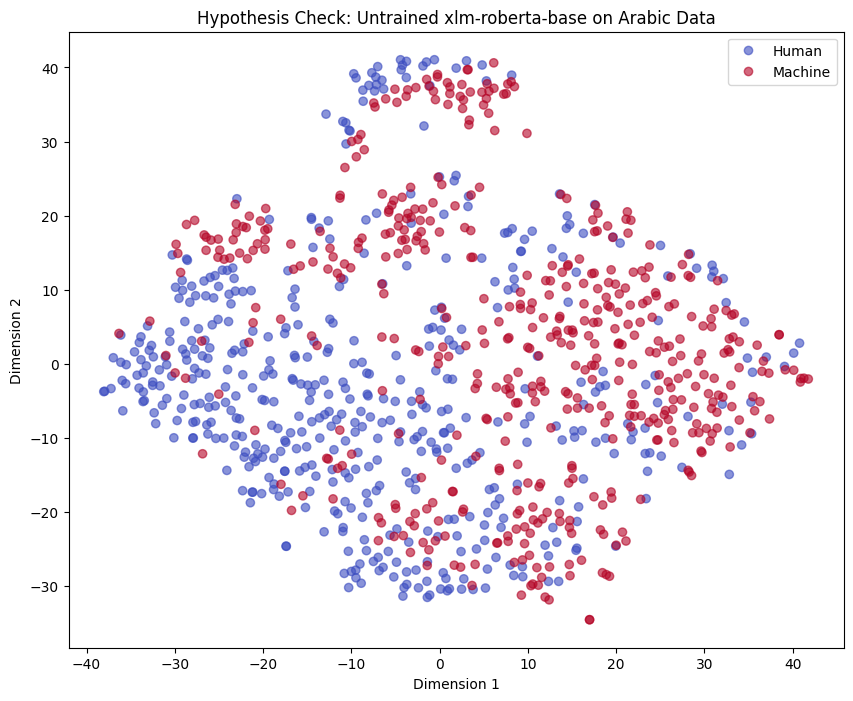

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST: Zero-Shot Clustering Check (Untrained Model on Arabic)
# Purpose: Check if the raw XLM-R model already separates Arabic Human/AI text.
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST: Untrained Embedding Analysis ---")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the TARGET Data (Arabic) to check pre-existing knowledge
# We define a temporary cleaner here to ensure this block is self-contained
def temp_clean(text):
    text = str(text).strip()
    # Basic cleaning to remove noise that might distract the plotting
    text = re.sub(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Loading Target Data (Arabic/Ground Truth) for zero-shot check...")
df_target_check = pd.read_csv('ground_truth.csv') # The Arabic File
df_target_check = df_target_check.drop(columns=['id'])
label_map_check = {"human": 0, "machine": 1}
df_target_check["label"] = df_target_check["label"].map(label_map_check)

# Sample 500 from each class to keep the plot readable and fast
df_h = df_target_check[df_target_check['label']==0].sample(n=500, random_state=42)
df_m = df_target_check[df_target_check['label']==1].sample(n=500, random_state=42)
df_viz = pd.concat([df_h, df_m]).reset_index(drop=True)

# 2. Load Raw Model (Just the Encoder, NO Classification Head)
print(f"Loading raw {MODEL_NAME}...")
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
temp_model = AutoModel.from_pretrained(MODEL_NAME).to(torch.device("cuda"))
temp_model.eval()

# 3. Extract Embeddings
print("Extracting embeddings from raw model...")
embeddings = []
labels_viz = df_viz['label'].tolist()
texts_viz = df_viz['content'].astype(str).apply(temp_clean).tolist()

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_viz), batch_size_viz):
        batch_txt = texts_viz[i:i+batch_size_viz]
        inputs = temp_tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(torch.device("cuda"))
        outputs = temp_model(**inputs)
        # Use CLS token (index 0) as the sentence representation
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

X_viz = np.vstack(embeddings)

# 4. t-SNE Projection
print("Calculating t-SNE (this might take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_viz)

# 5. Save the Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_viz, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine'])
plt.title(f"Hypothesis Check: Untrained {MODEL_NAME} on Arabic Data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig("hypothesis_check_untrained.png")
print("Saved plot to 'hypothesis_check_untrained.png'")
print("--- TEST COMPLETE: Starting Normal Training Pipeline ---\n")

# Clean up to free memory
del temp_model
del temp_tokenizer
del df_target_check
torch.cuda.empty_cache()
# ==================================================================================

# For external datset Tsne


--- RUNNING HYPOTHESIS TEST 1: Untrained Model on Parquet Data ---
Loading Parquet Data for zero-shot check...
Loading raw xlm-roberta-base...
Extracting embeddings...
Calculating t-SNE...
Saved plot to 'hypothesis_parquet_untrained.png'
--- TEST 1 COMPLETE ---



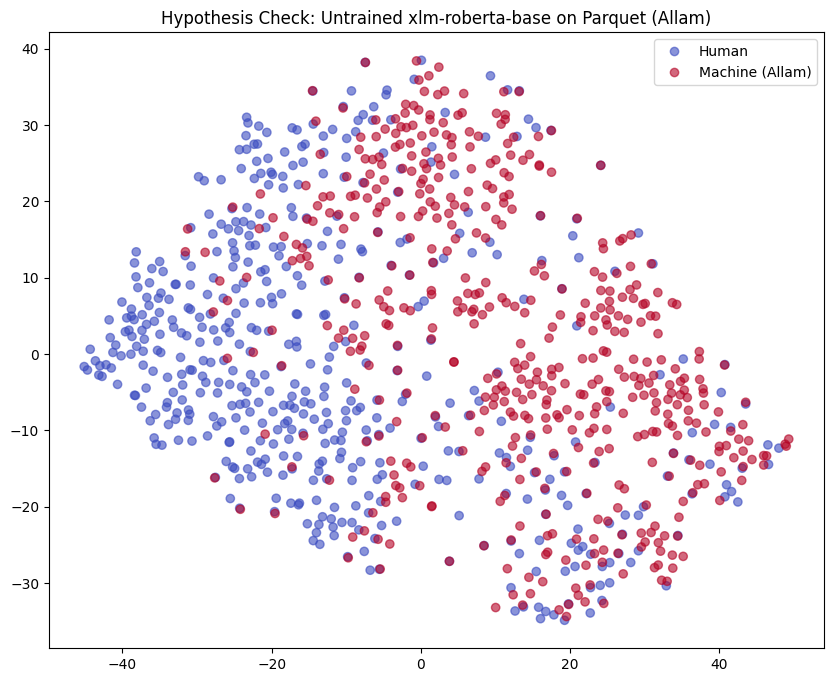

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST 1: Untrained Embedding Analysis on PARQUET Data
# Purpose: Check if untrained XLM-R separates Human vs. Allam (AI) text.
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST 1: Untrained Model on Parquet Data ---")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

# 1. Load the Parquet Data (Replicating your specific logic)
print("Loading Parquet Data for zero-shot check...")
df_parquet = pd.read_parquet("by_polishing-00000-of-00001.parquet")

# Helper to format data
def make_df_temp(col, df, label):
    out = df[[col]].rename(columns={col: "text"})
    out["label"] = label
    return out

# Using specifically 'allam_generated_abstract' as per your code (ai_cols[0])
human_col = 'original_abstract'
ai_col = 'allam_generated_abstract'

df_h = make_df_temp(human_col, df_parquet, 0)
df_a = make_df_temp(ai_col, df_parquet, 1)

# Sample 500 from each for the visualization
df_viz = pd.concat([df_h.sample(n=500, random_state=42),
                    df_a.sample(n=500, random_state=42)]).reset_index(drop=True)

# Define simple cleaner for this block
def temp_clean_parquet(text):
    text = str(text).strip()
    text = re.sub(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 2. Load Raw Model
print(f"Loading raw {MODEL_NAME}...")
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
temp_model = AutoModel.from_pretrained(MODEL_NAME).to(torch.device("cuda"))
temp_model.eval()

# 3. Extract Embeddings
print("Extracting embeddings...")
embeddings = []
labels_viz = df_viz['label'].tolist()
texts_viz = df_viz['text'].astype(str).apply(temp_clean_parquet).tolist()

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_viz), batch_size_viz):
        batch_txt = texts_viz[i:i+batch_size_viz]
        inputs = temp_tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(torch.device("cuda"))
        outputs = temp_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

X_viz = np.vstack(embeddings)

# 4. t-SNE & Plot
print("Calculating t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_viz)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_viz, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine (Allam)'])
plt.title(f"Hypothesis Check: Untrained {MODEL_NAME} on Parquet (Allam)")
plt.savefig("hypothesis_parquet_untrained.png")
print("Saved plot to 'hypothesis_parquet_untrained.png'")
print("--- TEST 1 COMPLETE ---\n")

# Cleanup
del temp_model
del temp_tokenizer
del df_parquet
torch.cuda.empty_cache()
# ==================================================================================

In [ ]:
df = pd.read_csv('urdu_train.csv')
stopwords_arabic = set(stopwords.words('arabic'))

# Arabic Text Cleaning Functions
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def numbers_to_arabic_words(text):
    def replace(match):
        num = int(match.group())
        return num2words(num, lang='ar')
    return re.sub(r'\d+', replace, text)

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = remove_urls_handles(text)
    # text = remove_punctuation(text)

    text = normalize_whitespace(text)
    return text

cleaned_texts = df["text"].astype(str).apply(clean_text).tolist()
labels = torch.tensor(df['label'].values, dtype=torch.long)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

In [ ]:
# Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == batch_labels).sum().item()
        train_total += batch_labels.size(0)

    train_acc = train_correct / train_total

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")


/tmp/ipython-input-2229955769.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1 | Train Loss: 54.6300 | Train Acc: 0.9438
Epoch 2 | Train Loss: 14.2702 | Train Acc: 0.9887
Epoch 3 | Train Loss: 7.4695 | Train Acc: 0.9938


In [ ]:
# Testing on a different dataset

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item


In [ ]:
df = pd.read_parquet("by_polishing-00000-of-00001.parquet")

human_col = 'original_abstract'
ai_cols = [
    'allam_generated_abstract',
    'jais_generated_abstract',
    'llama_generated_abstract',
    'openai_generated_abstract'
]

def make_df(col, df, label):
    out = df[[col]].rename(columns={col: "text"})
    out["label"] = label
    return out

df_human = make_df(human_col, df, 0)
df_ai = make_df(ai_cols[0], df, 1)

df_test = pd.concat([df_human[:1000], df_ai[:1000]], ignore_index=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_test["text"] = df_test["text"].astype(str).apply(clean_text)

test_dataset = InferenceDataset(
    texts=df_test["text"].tolist(),
    labels=df_test["label"].values,
    tokenizer=tokenizer
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(
    true_labels,
    preds,
    target_names=["human", "machine"],
    digits=3
))

print("Macro F1:", f1_score(true_labels, preds, average="macro"))

Classification Report:
              precision    recall  f1-score   support

       human      0.896     0.147     0.253      1000
     machine      0.535     0.983     0.693      1000

    accuracy                          0.565      2000
   macro avg      0.716     0.565     0.473      2000
weighted avg      0.716     0.565     0.473      2000

Macro F1: 0.4729036104285112


In [ ]:
test_arabic = pd.read_csv("ground_truth.csv")
test_arabic = test_arabic.drop(columns=['id'])

label_map = {"human": 0, "machine": 1}
test_arabic["label"] = test_arabic["label"].map(label_map)

test_arabic = test_arabic.sample(frac=1, random_state=42).reset_index(drop=True)

def clean_text(text):
    text = str(text).strip()

    text = remove_emojis(text)
    # text = numbers_to_arabic_words(text)
    text = remove_urls_handles(text)

    text = normalize_arabic(text)
    # text = remove_diacritics(text)
    text = remove_tatweel(text)
    # text = remove_punctuation(text)

    text = normalize_whitespace(text)
    return text

urdu_dataset = InferenceDataset(
    texts=test_arabic["content"].astype(str).apply(clean_text).tolist(),
    labels=test_arabic["label"].values,
    tokenizer=tokenizer
)

urdu_loader = DataLoader(
    urdu_dataset,
    batch_size=32,
    shuffle=False
)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in urdu_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(
    true_labels,
    preds,
    target_names=["human", "machine"],
    digits=3
))

print("Macro F1:", f1_score(true_labels, preds, average="macro"))

Classification Report:
              precision    recall  f1-score   support

       human      0.872     0.606     0.715      2649
     machine      0.698     0.911     0.790      2649

    accuracy                          0.758      5298
   macro avg      0.785     0.758     0.753      5298
weighted avg      0.785     0.758     0.753      5298

Macro F1: 0.7526460883704881



--- RUNNING HYPOTHESIS TEST 2: Trained Model on Arabic ---
Loading Target Data (Arabic) for trained visualization...
Extracting embeddings from TRAINED model...
Calculating t-SNE for trained model...
Saved plot to 'hypothesis_check_TRAINED.png'
--- HYPOTHESIS TEST 2 COMPLETE ---


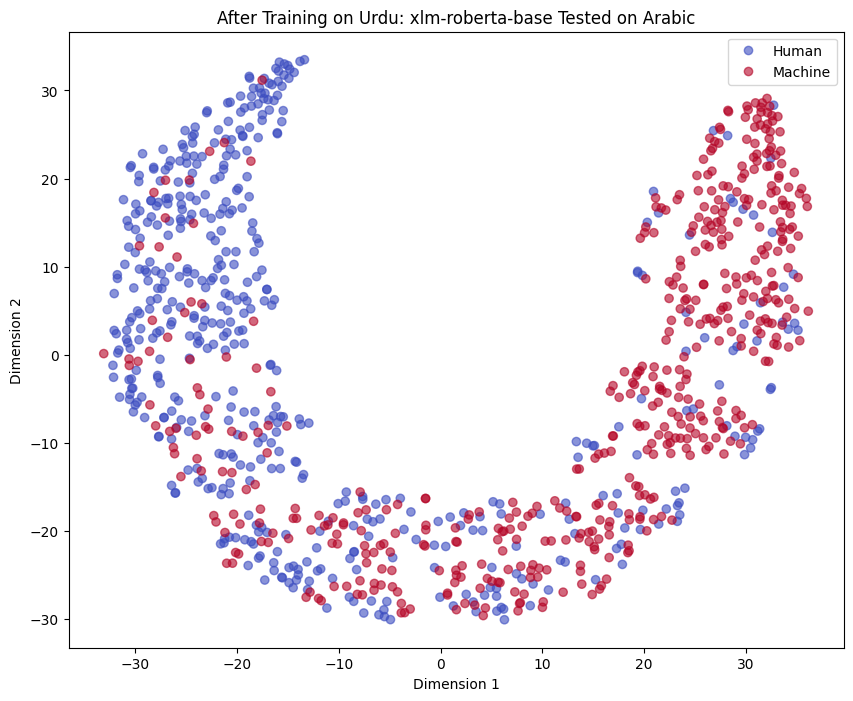

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST 2: Trained Embedding Analysis (The "After" Shot)
# Purpose: See if Urdu training successfully separated the Arabic clusters.
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST 2: Trained Model on Arabic ---")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# 1. Re-load the Target Data (Arabic)
# We use the same sampling logic as the first test to ensure a fair comparison
print("Loading Target Data (Arabic) for trained visualization...")
df_target_after = pd.read_csv('ground_truth.csv')
df_target_after = df_target_after.drop(columns=['id'])
label_map_after = {"human": 0, "machine": 1}
df_target_after["label"] = df_target_after["label"].map(label_map_after)

# Sample 500 from each class (Same as before)
df_h = df_target_after[df_target_after['label']==0].sample(n=500, random_state=42)
df_m = df_target_after[df_target_after['label']==1].sample(n=500, random_state=42)
df_viz_after = pd.concat([df_h, df_m]).reset_index(drop=True)

# 2. Extract Embeddings using the TRAINED model
print("Extracting embeddings from TRAINED model...")
embeddings_after = []
labels_after = df_viz_after['label'].tolist()
# Use the main 'clean_text' function you defined in your script
texts_after = df_viz_after['content'].astype(str).apply(clean_text).tolist()

model.eval() # Ensure model is in eval mode

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_after), batch_size_viz):
        batch_txt = texts_after[i:i+batch_size_viz]

        # Use the global tokenizer and device
        inputs = tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        # Pass through the BERT part of your classifier
        # Note: Your model class is 'BertClassifier', so we access 'model.bert' to get raw embeddings
        outputs = model.bert(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

        # Get CLS token (index 0)
        cls_rep = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings_after.append(cls_rep)

X_viz_after = np.vstack(embeddings_after)

# 3. t-SNE Projection
print("Calculating t-SNE for trained model...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded_after = tsne.fit_transform(X_viz_after)

# 4. Save the Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded_after[:, 0], X_embedded_after[:, 1], c=labels_after, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine'])
plt.title(f"After Training on Urdu: {MODEL_NAME} Tested on Arabic")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig("hypothesis_check_TRAINED.png")
print("Saved plot to 'hypothesis_check_TRAINED.png'")
print("--- HYPOTHESIS TEST 2 COMPLETE ---")

In [ ]:
# for external dataset


--- RUNNING HYPOTHESIS TEST 2: Trained Model on Parquet Data ---
Loading Parquet Data for trained visualization...
Extracting embeddings from TRAINED model...
Calculating t-SNE...
Saved plot to 'hypothesis_parquet_TRAINED.png'
--- TEST 2 COMPLETE ---


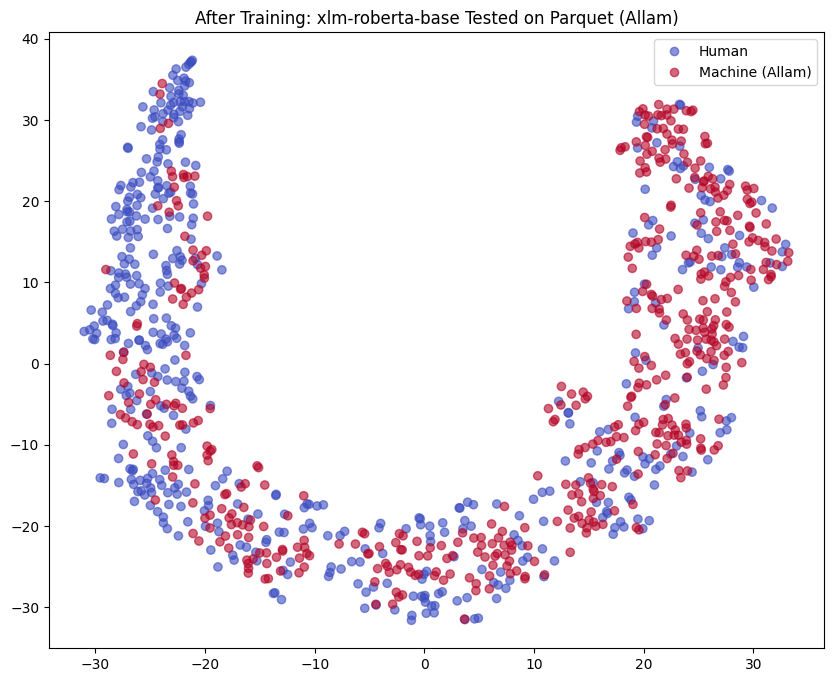

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST 2: Trained Embedding Analysis on PARQUET Data
# Purpose: Did training help separate Human vs. Allam text?
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST 2: Trained Model on Parquet Data ---")

# 1. Re-load Data
print("Loading Parquet Data for trained visualization...")
df_parquet_after = pd.read_parquet("by_polishing-00000-of-00001.parquet")

df_h_after = make_df(human_col, df_parquet_after, 0) # Using your existing make_df function
df_a_after = make_df(ai_cols[0], df_parquet_after, 1) # ai_cols[0] is Allam

# Sample 500
df_viz_after = pd.concat([df_h_after.sample(n=500, random_state=42),
                          df_a_after.sample(n=500, random_state=42)]).reset_index(drop=True)

# 2. Extract Embeddings using TRAINED model
print("Extracting embeddings from TRAINED model...")
embeddings_after = []
labels_after = df_viz_after['label'].tolist()
texts_after = df_viz_after['text'].astype(str).apply(clean_text).tolist() # Use main cleaner

model.eval()

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_after), batch_size_viz):
        batch_txt = texts_after[i:i+batch_size_viz]
        inputs = tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        # Access .bert to get raw embeddings
        outputs = model.bert(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        embeddings_after.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

X_viz_after = np.vstack(embeddings_after)

# 3. t-SNE & Plot
print("Calculating t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded_after = tsne.fit_transform(X_viz_after)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded_after[:, 0], X_embedded_after[:, 1], c=labels_after, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine (Allam)'])
plt.title(f"After Training: {MODEL_NAME} Tested on Parquet (Allam)")
plt.savefig("hypothesis_parquet_TRAINED.png")
print("Saved plot to 'hypothesis_parquet_TRAINED.png'")
print("--- TEST 2 COMPLETE ---")

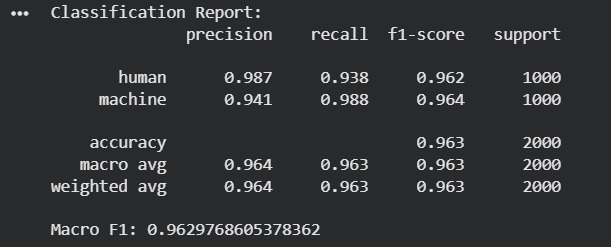

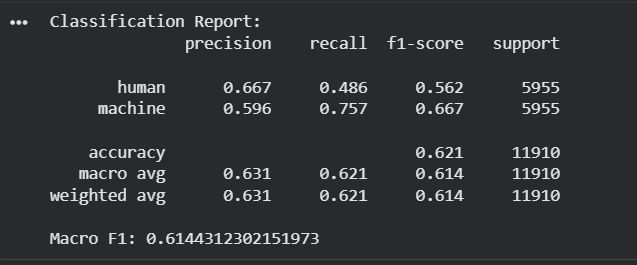

In [ ]:
# model -> 2 (bert multilingual)

In [ ]:
# removing punctuations

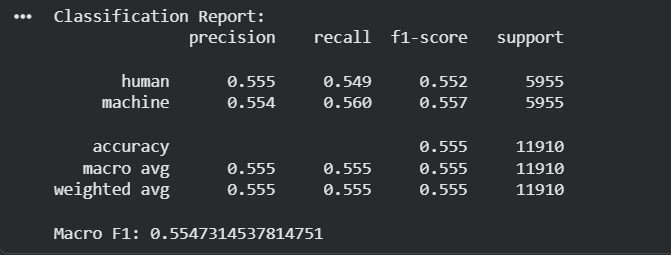

In [ ]:
# without removing punctuations from both datasets

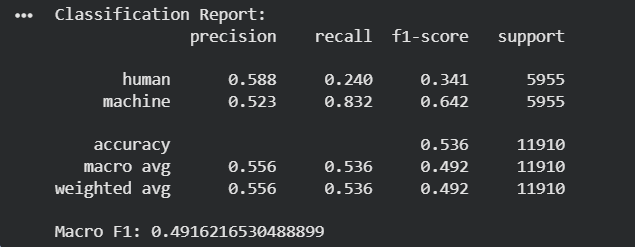

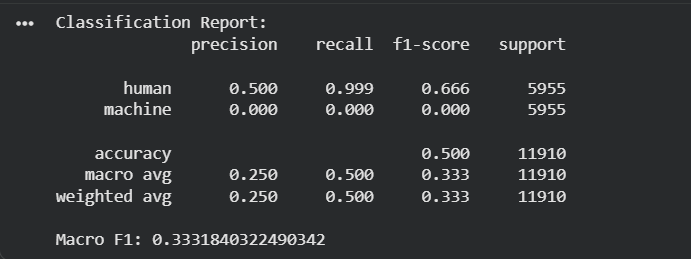